In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.utils import shuffle


warnings.filterwarnings("ignore")
%matplotlib inline

/home/teknus/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Preprocessing

## Feature Engineering

In [2]:
file= open('bots.1k.csv', mode='r', encoding='utf-8', errors='ignore')
bots1k = pd.read_csv(file)
file= open('humans.1k.csv', mode='r', encoding='utf-8', errors='ignore')
humans1k = pd.read_csv(file)
bots1k['bot'] = 1
humans1k['bot'] = 0
print(len(bots1k),len(humans1k))
print(len(bots1k) + len(humans1k))
humasn1k = shuffle(humans1k)
humans1k = humans1k.iloc[0:len(bots1k)]
print(len(bots1k),len(humans1k))
print(len(bots1k) + len(humans1k))

498 791
1289
498 498
996


In [3]:
file= open('bots.100k.csv', mode='r', encoding='utf-8', errors='ignore')
bots100k = pd.read_csv(file)
file= open('humans.100k.csv', mode='r', encoding='utf-8', errors='ignore')
humans100k = pd.read_csv(file)
bots100k['bot'] = 1
humans100k['bot'] = 0
print(len(bots100k),len(humans100k))
print(len(bots100k) + len(humans100k))
humasn100k = shuffle(humans100k)
humans100k = humans100k.iloc[0:len(bots100k)]
print(len(bots100k),len(humans100k))
print(len(bots100k) + len(humans100k))


704 734
1438
704 704
1408


In [4]:
file= open('bots.1M.csv', mode='r', encoding='utf-8', errors='ignore')
bots1M = pd.read_csv(file)
file= open('humans.1M.csv', mode='r', encoding='utf-8', errors='ignore')
humans1M = pd.read_csv(file)
bots1M['bot'] = 1
humans1M['bot'] = 0
print(len(bots1M),len(humans1M))
print(len(bots1M) + len(humans1M))
humasn1M = shuffle(humans1M)
humans1M = humans1M.iloc[0:len(bots1M)]
print(len(bots1M),len(humans1M))
print(len(bots1M) + len(humans1M))

265 389
654
265 265
530


In [5]:
file= open('bots.10M.csv', mode='r', encoding='utf-8', errors='ignore')
bots10M = pd.read_csv(file)
file= open('humans.10M.csv', mode='r', encoding='utf-8', errors='ignore')
humans10M = pd.read_csv(file)
bots10M['bot'] = 1
humans10M['bot'] = 0
print(len(bots10M),len(humans10M))
print(len(bots10M) + len(humans10M))
humasn10M = shuffle(humans10M)
humans10M = humans10M.iloc[0:len(bots10M)]
print(len(bots10M),len(humans10M))
print(len(bots10M) + len(humans10M))

25 25
50
25 25
50


In [6]:
ratio = 0.70
humans_train1k = humans1k.sample(frac=ratio,random_state=200)
humans_test1k = humans1k.drop(humans_train1k.index)
humans_train100k = humans100k.sample(frac=ratio,random_state=200)
humans_test100k = humans100k.drop(humans_train100k.index)
humans_train1M = humans1M.sample(frac=ratio,random_state=200)
humans_test1M = humans1M.drop(humans_train1M.index)
humans_train10M = humans10M.sample(frac=ratio,random_state=200)
humans_test10M = humans10M.drop(humans_train10M.index)

humans_train = pd.concat([humans_train1k,humans_train100k,humans_train1M,humans_train10M],ignore_index=True)
humans_test = pd.concat([humans_test1k,humans_test100k,humans_test1M,humans_test10M],ignore_index=True)

bots_train1k = bots1k.sample(frac=ratio,random_state=200)
bots_test1k = bots1k.drop(bots_train1k.index)
bots_train100k = bots100k.sample(frac=ratio,random_state=200)
bots_test100k = bots100k.drop(bots_train100k.index)
bots_train1M = bots1M.sample(frac=ratio,random_state=200)
bots_test1M = bots1M.drop(bots_train1M.index)
bots_train10M = bots10M.sample(frac=ratio,random_state=200)
bots_test10M = bots10M.drop(bots_train10M.index)

bots_train = pd.concat([bots_train1k,bots_train100k,bots_train1M,bots_train10M],ignore_index=True)
bots_test = pd.concat([bots_test1k,bots_test100k,bots_test1M,bots_test10M],ignore_index=True)
print(len(bots_train) + len(humans_train) + len(bots_test) +len(humans_test))

2984


In [7]:
bots_train = bots_train.drop(['source_identity','screen_name','cdn_content_in_kb'], axis=1)
humans_train = humans_train.drop(['source_identity','screen_name','cdn_content_in_kb','sources_count'], axis=1)
bots_test = bots_test.drop(['source_identity','screen_name','cdn_content_in_kb'], axis=1)
humans_test = humans_test.drop(['source_identity','screen_name','cdn_content_in_kb','sources_count'], axis=1)

## Feature Extraction

In [8]:
features = ['user_tweeted',
            'user_retweeted',
            'user_favourited',
            'user_replied',
            'likes_per_tweet',
            'retweets_per_tweet',
            'lists_per_user',
            'follower_friend_ratio',
            'tweet_frequency',
            'favourite_tweet_ratio',
            'age_of_account_in_days',
            'urls_count']

from itertools import combinations

comb = []

for item in filter(lambda i:len(i) >= 2, [list(map(list, combinations(features, i))) for i in range(len(features) + 1)]):
  for i in item:
    if len(i) >= 3 and len(i) < len(features):
      if i not in comb:
        comb.append(i)

In [9]:
comb.sort(key=lambda i: len(i))
len(features)

12

### Merge dataset to train

In [10]:
train = pd.concat([bots_train,humans_train],ignore_index=True)
test = pd.concat([bots_test,humans_test],ignore_index=True)
concant = pd.concat([train,test],ignore_index=True)
X = concant[features]
y =concant['bot']

### Plain data metrics

In [11]:
for i in range(0,3):
  db = KMeans(n_clusters=2,  max_iter = 600).fit(X[features])

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))
  print("Kmeans density of bots {:f}".format(metrics.silhouette_score(X, labels)))


Kmeans silhouette of bots 0.997556
Kmeans homogeneity of bots 0.000335
Kmeans density of bots 0.997556
Kmeans silhouette of bots 0.997556
Kmeans homogeneity of bots 0.000335
Kmeans density of bots 0.997556
Kmeans silhouette of bots 0.997556
Kmeans homogeneity of bots 0.000335
Kmeans density of bots 0.997556


### Noramlization

In [12]:
from sklearn.preprocessing import MinMaxScaler

X_train = MinMaxScaler().fit_transform(train[features])
y_train = train['bot']
X_test = MinMaxScaler().fit_transform(test[features])
y_test = test['bot']
X_norm = MinMaxScaler().fit_transform(X[features])

In [13]:
X_train_u = train[features]
y_train_u = train['bot']
X_test_u = test[features]
y_test_u = test['bot']
X_norm_u = X[features]

### Plain Normalized data metrics

In [14]:
for i in range(0,3):
  db = KMeans(n_clusters=2).fit(X_norm)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X_norm, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))

Kmeans silhouette of bots 0.545258
Kmeans homogeneity of bots 0.000778
Kmeans silhouette of bots 0.545258
Kmeans homogeneity of bots 0.000778
Kmeans silhouette of bots 0.545258
Kmeans homogeneity of bots 0.000778


### Brute Force feature selection

In [15]:
from sys import stdout

homogeneity = []
i = len(comb)
for order in comb:
  stdout.write("\r%d" % i)
  stdout.flush()
  i -= 1
  X_bt = X[order]
  y_bt = y

  db = KMeans(n_clusters=2,max_iter = 600).fit(X_bt)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_
  
  homogeneity.append([order,metrics.homogeneity_score(y_bt, labels)])

1000

In [21]:
homogeneity.sort(key=lambda i: -1 * i[1])
X_brut = MinMaxScaler().fit_transform(X[homogeneity[0][0]])

X_train_brut, X_test_brut= MinMaxScaler().fit_transform(train[homogeneity[0][0]]),MinMaxScaler().fit_transform(test[homogeneity[0][0]])

X_brut_u = X[homogeneity[0][0]]

X_train_brut_u, X_test_brut_u= train[homogeneity[0][0]],test[homogeneity[0][0]]

### Feature Validation by Homogenity on clusters K-means using brutforced features

In [22]:
for i in range(0,3):
  db = KMeans(n_clusters=2).fit(X_brut)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X_brut, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))

Kmeans silhouette of bots 0.927155
Kmeans homogeneity of bots 0.007412
Kmeans silhouette of bots 0.927155
Kmeans homogeneity of bots 0.007412
Kmeans silhouette of bots 0.927155
Kmeans homogeneity of bots 0.007412


### Feature Validation by Homogenity on clusters K-means using brutforced features unormalized

In [23]:
for i in range(0,3):
  db = KMeans(n_clusters=2).fit(X_brut_u)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X_brut_u, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))

Kmeans silhouette of bots 0.933815
Kmeans homogeneity of bots 0.007751
Kmeans silhouette of bots 0.933815
Kmeans homogeneity of bots 0.007751
Kmeans silhouette of bots 0.933815
Kmeans homogeneity of bots 0.007751


#### Metrics

In [24]:
def show_metrics_test(y_test, y_pred_test):
    print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
    print("F1 score test {}".format(f1_score(y_test,y_pred_test)))
    print("Precision score test {}".format(precision_score(y_test,y_pred_test)))
    print("Recall score test {}".format(recall_score(y_test,y_pred_test)))
    print("Confusion Matrix score test {}".format(confusion_matrix(y_test,y_pred_test)))

def show_metrics_train(y_train,y_pred_train):
    print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
    print("F1 score train {}".format(f1_score(y_train,y_pred_train)))
    print("Precision score train {}".format(precision_score(y_train,y_pred_train)))
    print("Recall score train {}".format(recall_score(y_train,y_pred_train)))
    print("Confusion Matrix score train {}".format(confusion_matrix(y_train,y_pred_train)))

def show_curve(clf,X_train, y_train, X_test, y_test):
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})

    scores_train = clf.predict_proba(X_train)
    scores_test = clf.predict_proba(X_test)

    y_scores_train = []
    y_scores_test = []
    for i in range(len(scores_train)):
        y_scores_train.append(scores_train[i][1])

    for i in range(len(scores_test)):
        y_scores_test.append(scores_test[i][1])

    fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
    fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

    plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %2f' %auc(fpr_dt_train, tpr_dt_train))
    plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %2f' %auc(fpr_dt_test, tpr_dt_test))
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='lower right')

## Models

In [25]:
def runner(clf,negative=True,cv=10):  
  print("Normalized")
  x = X_norm
  scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
  print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
  print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
  print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  print("BrutForce")
  x = X_brut
  scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
  print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
  print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
  print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  if negative:
    print("PCA")
    x = X_pca
    scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
    print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
    print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
    print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("LDA")
    x = X_lda
    scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
    print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
    print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
    print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
def split_runner(clf,X_train, y_train, X_test, y_test,roc=True):
  clf = clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
  show_metrics_train(y_train, y_pred_train)
  show_metrics_test(y_test, y_pred_test)
  if roc:
    show_curve(clf,X_train, y_train, X_test, y_test)
  return clf

#### training

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [2,10,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2,10,100,200]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1)
CV_rfc.fit(X_train_brut, y_train)
CV_rfc.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1501 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.0min finished


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'n_estimators': 200}

Trainig Accuracy: 0.71128
F1 score train 0.6970912738214644
Precision score train 0.7331223628691983
Recall score train 0.6644359464627151
Confusion Matrix score train [[793 253]
 [351 695]]
Test Accuracy: 0.70740
F1 score test 0.653386454183267
Precision score test 0.8013029315960912
Recall score test 0.5515695067264574
Confusion Matrix score test [[385  61]
 [200 246]]


['random_forest_classifier.pkl']

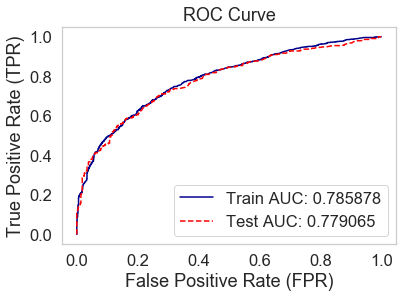

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion= 'gini',
 max_depth= 4,
 max_features= 'auto',
 min_samples_leaf= 10,
 n_estimators= 200)
clf = split_runner(clf,X_train_brut, y_train, X_test_brut, y_test)
filename = 'random_forest_classifier.pkl'
joblib.dump(clf, filename)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,9,11,13,15,21,23,47],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1,n_jobs=-1)
CV_clf.fit(X_train_brut, y_train)
CV_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.8s finished


{'metric': 'euclidean', 'n_neighbors': 47, 'weights': 'uniform'}

Trainig Accuracy: 0.70363
F1 score train 0.6918489065606362
Precision score train 0.7204968944099379
Recall score train 0.6653919694072657
Confusion Matrix score train [[776 270]
 [350 696]]
Test Accuracy: 0.70404
F1 score test 0.6535433070866141
Precision score test 0.7879746835443038
Recall score test 0.5582959641255605
Confusion Matrix score test [[379  67]
 [197 249]]


['knn_classifier.pkl']

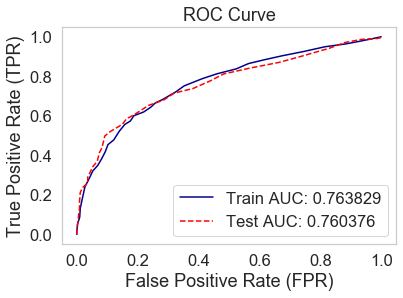

In [29]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric = 'euclidean', n_neighbors= 47, weights= 'uniform')

clf = split_runner(clf,X_train_brut, y_train, X_test_brut, y_test)
filename = 'knn_classifier.pkl'
joblib.dump(clf, filename)

## Vote

Trainig Accuracy: 0.70937
F1 score train 0.6926188068756319
Precision score train 0.7349785407725322
Recall score train 0.6548757170172084
Confusion Matrix score train [[799 247]
 [361 685]]
Test Accuracy: 0.70404
F1 score test 0.649867374005305
Precision score test 0.7954545454545454
Recall score test 0.5493273542600897
Confusion Matrix score test [[383  63]
 [201 245]]


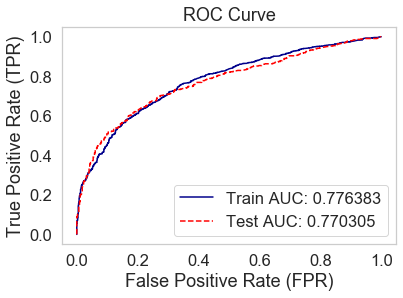

In [30]:
rf = joblib.load("random_forest_classifier.pkl")
knn = joblib.load("knn_classifier.pkl")

from sklearn.ensemble import VotingClassifier
est = [('knn', knn),('rf',rf)]
clf = VotingClassifier(estimators=est,
                        voting='soft',weights= [0.57,0.43])

a = split_runner(clf,X_train_brut, y_train, X_test_brut, y_test)

## Train Full feautres

In [31]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [2,10,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2,10,100,200]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1,scoring="f1")
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 299 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 1102 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1645 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.4min finished


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 100}

Trainig Accuracy: 0.91778
F1 score train 0.9144278606965175
Precision score train 0.9533195020746889
Recall score train 0.878585086042065
Confusion Matrix score train [[1001   45]
 [ 127  919]]
Test Accuracy: 0.71413
F1 score test 0.7457627118644067
Precision score test 0.6714542190305206
Recall score test 0.8385650224215246
Confusion Matrix score test [[263 183]
 [ 72 374]]


['random_forest_classifier_full.pkl']

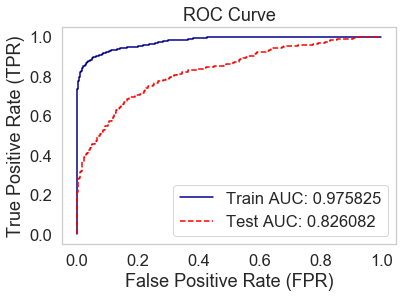

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion= 'entropy',
 max_depth= 10,
 max_features= 'auto',
 min_samples_leaf= 2,
 n_estimators= 100)
clf = split_runner(clf,X_train, y_train, X_test, y_test)
filename = 'random_forest_classifier_full.pkl'
joblib.dump(clf, filename)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,9,11,13,15,21,23,47],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1,n_jobs=-1)
CV_clf.fit(X_train, y_train)
CV_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.0s finished


{'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance'}

Trainig Accuracy: 1.00000
F1 score train 1.0
Precision score train 1.0
Recall score train 1.0
Confusion Matrix score train [[1046    0]
 [   0 1046]]
Test Accuracy: 0.66031
F1 score test 0.5888738127544099
Precision score test 0.7457044673539519
Recall score test 0.48654708520179374
Confusion Matrix score test [[372  74]
 [229 217]]


['knn_classifier_full.pkl']

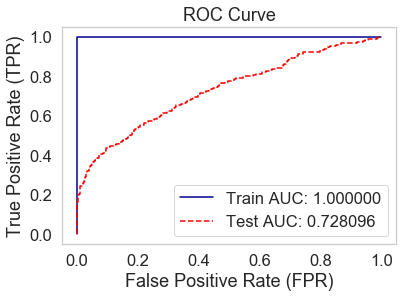

In [34]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric = 'manhattan', n_neighbors= 47, weights= 'distance')

clf = split_runner(clf,X_train, y_train, X_test, y_test)
filename = 'knn_classifier_full.pkl'
joblib.dump(clf, filename)

Trainig Accuracy: 1.00000
F1 score train 1.0
Precision score train 1.0
Recall score train 1.0
Confusion Matrix score train [[1046    0]
 [   0 1046]]
Test Accuracy: 0.72646
F1 score test 0.7142857142857143
Precision score test 0.7475490196078431
Recall score test 0.6838565022421524
Confusion Matrix score test [[343 103]
 [141 305]]


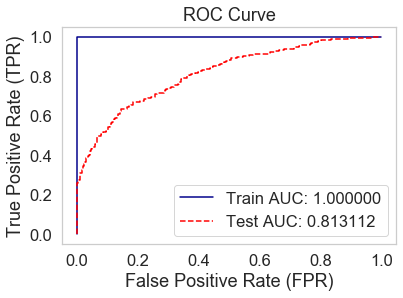

In [35]:
rf = joblib.load("random_forest_classifier_full.pkl")
knn = joblib.load("knn_classifier_full.pkl")

from sklearn.ensemble import VotingClassifier
est = [('knn', knn),('rf',rf)]
clf = VotingClassifier(estimators=est,
                        voting='soft',weights= [0.57,0.43])

clf = split_runner(clf,X_train, y_train, X_test, y_test)

## Unormalized reesults

### Brut

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [2,10,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2,10,100,200]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1)
CV_rfc.fit(X_train_brut_u, y_train_u)
CV_rfc.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 567 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 1067 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1767 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1913 out of 1920 | elapsed:  1.8min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.8min finished


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'n_estimators': 200}

Trainig Accuracy: 0.71558
F1 score train 0.7032418952618454
Precision score train 0.735140771637122
Recall score train 0.6739961759082218
Confusion Matrix score train [[792 254]
 [341 705]]
Test Accuracy: 0.70179
F1 score test 0.6763990267639904
Precision score test 0.7393617021276596
Recall score test 0.6233183856502242
Confusion Matrix score test [[348  98]
 [168 278]]


['random_forest_classifier_u.pkl']

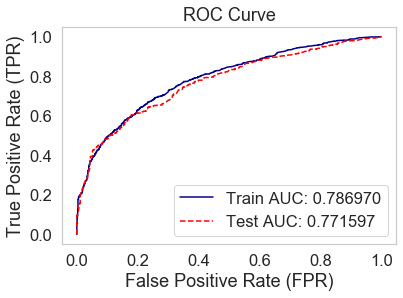

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion= 'gini',
 max_depth= 4,
 max_features= 'auto',
 min_samples_leaf= 10,
 n_estimators= 200)
clf = split_runner(clf,X_train_brut_u, y_train_u, X_test_brut_u, y_test_u)
filename = 'random_forest_classifier_u.pkl'
joblib.dump(clf, filename)

In [47]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,9,11,13,15,21,23,47],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1,n_jobs=-1)
CV_clf.fit(X_train_brut_u, y_train_u)
CV_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished


{'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'uniform'}

Trainig Accuracy: 0.70363
F1 score train 0.6918489065606362
Precision score train 0.7204968944099379
Recall score train 0.6653919694072657
Confusion Matrix score train [[776 270]
 [350 696]]
Test Accuracy: 0.70404
F1 score test 0.6535433070866141
Precision score test 0.7879746835443038
Recall score test 0.5582959641255605
Confusion Matrix score test [[379  67]
 [197 249]]


['knn_classifier_u.pkl']

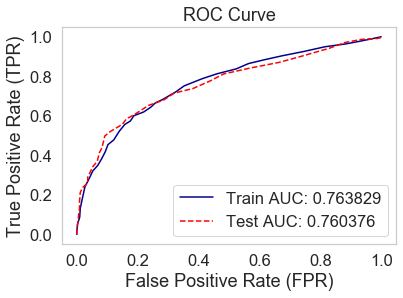

In [39]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric = 'euclidean', n_neighbors= 47, weights= 'uniform')

clf = split_runner(clf,X_train_brut_u, y_train_u, X_test_brut_u, y_test_u)
filename = 'knn_classifier_u.pkl'
joblib.dump(clf, filename)

Trainig Accuracy: 0.70985
F1 score train 0.6923466801824633
Precision score train 0.7367853290183387
Recall score train 0.652963671128107
Confusion Matrix score train [[802 244]
 [363 683]]
Test Accuracy: 0.70067
F1 score test 0.6723926380368098
Precision score test 0.7425474254742548
Recall score test 0.6143497757847534
Confusion Matrix score test [[351  95]
 [172 274]]


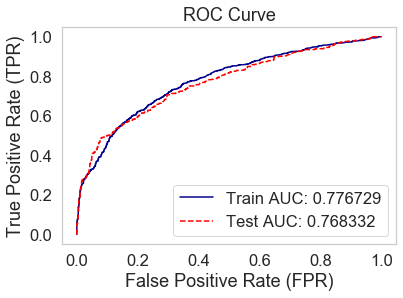

In [49]:
rf = joblib.load("random_forest_classifier_u.pkl")
knn = joblib.load("knn_classifier_u.pkl")

from sklearn.ensemble import VotingClassifier
est = [('knn', knn),('rf',rf)]
clf = VotingClassifier(estimators=est,
                        voting='soft',weights= [0.57,0.43])

clf = split_runner(clf,X_train_brut_u, y_train_u, X_test_brut_u, y_test_u)

### full

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [2,10,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2,10,100,200]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1,scoring="f1")
CV_rfc.fit(X_train_u, y_train_u)
CV_rfc.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 487 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 987 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.7min finished


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'n_estimators': 200}

Trainig Accuracy: 0.91874
F1 score train 0.9154228855721395
Precision score train 0.9543568464730291
Recall score train 0.8795411089866156
Confusion Matrix score train [[1002   44]
 [ 126  920]]
Test Accuracy: 0.71973
F1 score test 0.745417515274949
Precision score test 0.6828358208955224
Recall score test 0.820627802690583
Confusion Matrix score test [[276 170]
 [ 80 366]]


['random_forest_classifier_full_u.pkl']

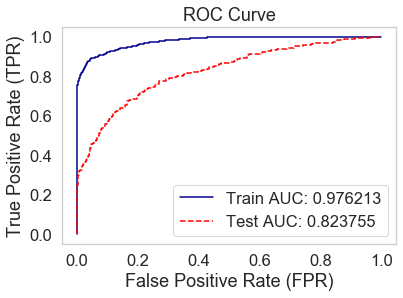

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion= 'entropy',
 max_depth= 10,
 max_features= 'auto',
 min_samples_leaf= 2,
 n_estimators= 100)
clf = split_runner(clf,X_train_brut_u, y_train_u, X_test_brut_u, y_test_u)
filename = 'random_forest_classifier_full_u.pkl'
joblib.dump(clf, filename)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,9,11,13,15,21,23,47],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1,n_jobs=-1)
CV_clf.fit(X_train_u, y_train_u)
CV_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.2s finished


{'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance'}

Trainig Accuracy: 1.00000
F1 score train 1.0
Precision score train 1.0
Recall score train 1.0
Confusion Matrix score train [[1046    0]
 [   0 1046]]
Test Accuracy: 0.66480
F1 score test 0.6486486486486486
Precision score test 0.6814814814814815
Recall score test 0.6188340807174888
Confusion Matrix score test [[317 129]
 [170 276]]


['knn_classifier_full_u.pkl']

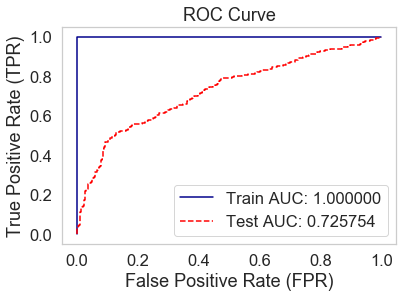

In [51]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric = 'manhattan', n_neighbors= 47, weights= 'distance')

clf = split_runner(clf,X_train_brut_u, y_train_u, X_test_brut_u, y_test_u)
filename = 'knn_classifier_full_u.pkl'
joblib.dump(clf, filename)

Trainig Accuracy: 1.00000
F1 score train 1.0
Precision score train 1.0
Recall score train 1.0
Confusion Matrix score train [[1046    0]
 [   0 1046]]
Test Accuracy: 0.68722
F1 score test 0.6642599277978339
Precision score test 0.7168831168831169
Recall score test 0.6188340807174888
Confusion Matrix score test [[337 109]
 [170 276]]


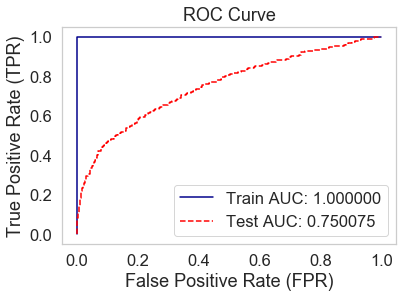

In [52]:
rf = joblib.load("random_forest_classifier_full_u.pkl")
knn = joblib.load("knn_classifier_full_u.pkl")

from sklearn.ensemble import VotingClassifier
est = [('knn', knn),('rf',rf)]
clf = VotingClassifier(estimators=est,
                        voting='soft',weights= [0.57,0.43])

clf = split_runner(clf,X_train_brut_u, y_train_u, X_test_brut_u, y_test_u)